Calculating coordination numbers for 2914 structures...
Processed 0/2914 structures
Processed 100/2914 structures
Processed 200/2914 structures
Processed 300/2914 structures
Processed 400/2914 structures
Processed 500/2914 structures
Processed 600/2914 structures
Processed 700/2914 structures
Processed 800/2914 structures
Processed 900/2914 structures
Processed 1000/2914 structures
Processed 1100/2914 structures
Processed 1200/2914 structures
Processed 1300/2914 structures
Processed 1400/2914 structures
Processed 1500/2914 structures
Processed 1600/2914 structures
Processed 1700/2914 structures
Processed 1800/2914 structures
Processed 1900/2914 structures
Processed 2000/2914 structures
Processed 2100/2914 structures
Processed 2200/2914 structures
Processed 2300/2914 structures
Processed 2400/2914 structures
Processed 2500/2914 structures
Processed 2600/2914 structures
Processed 2700/2914 structures
Processed 2800/2914 structures
Processed 2900/2914 structures


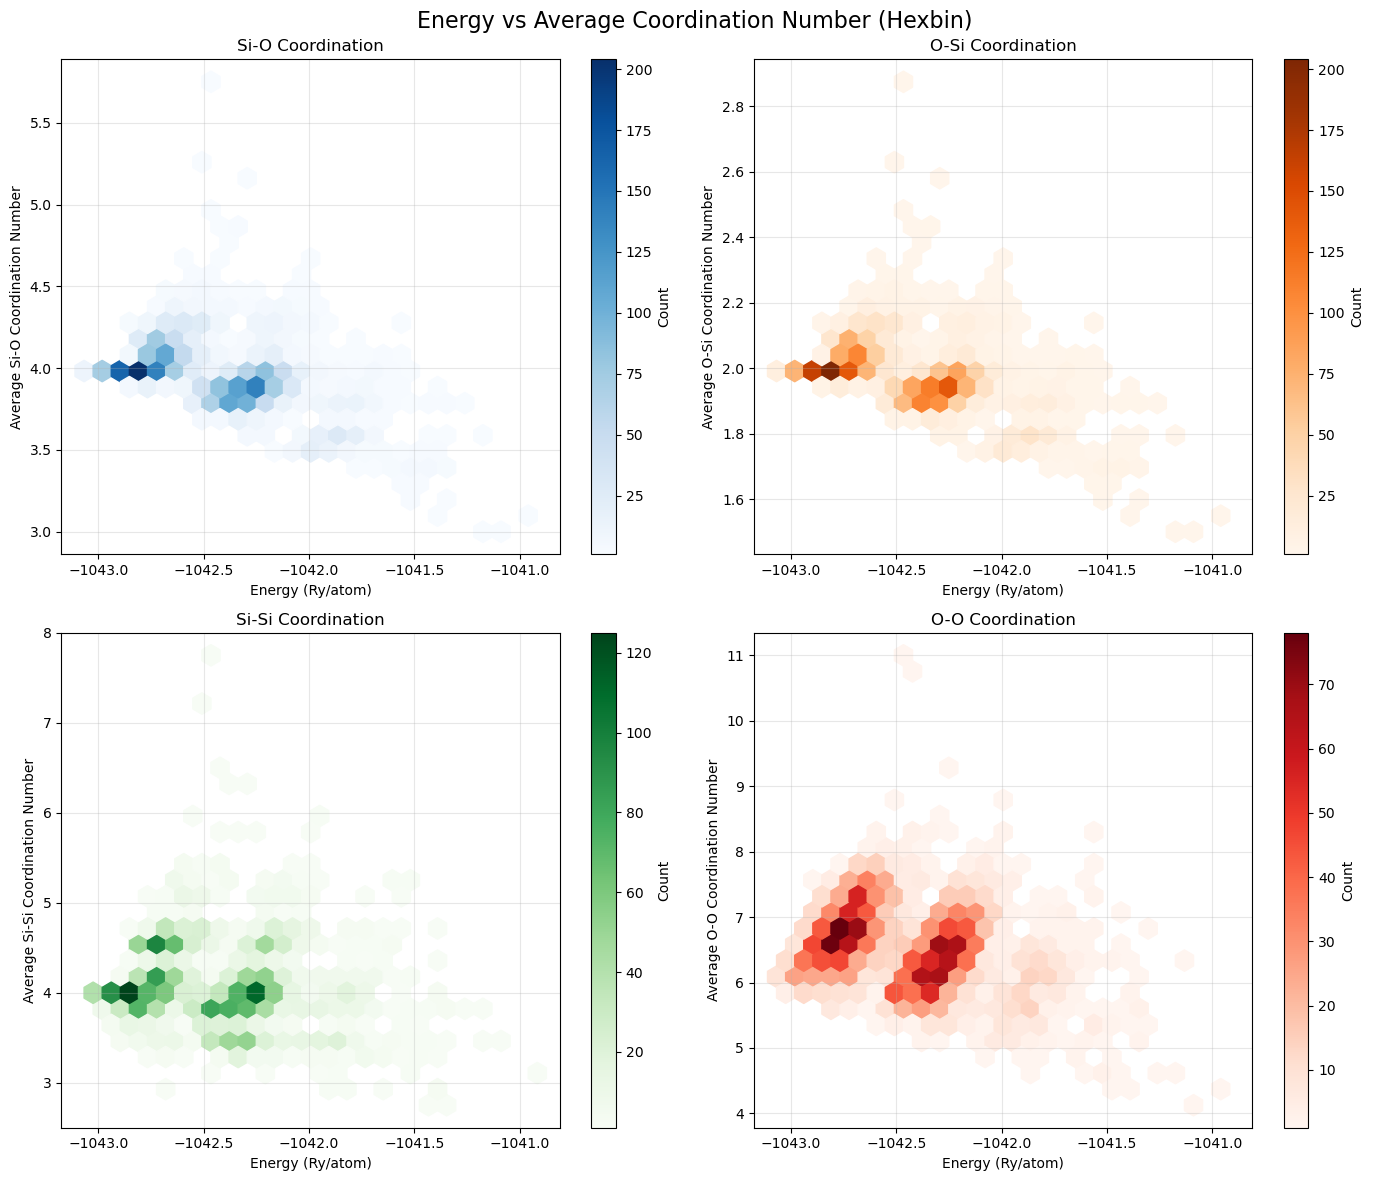

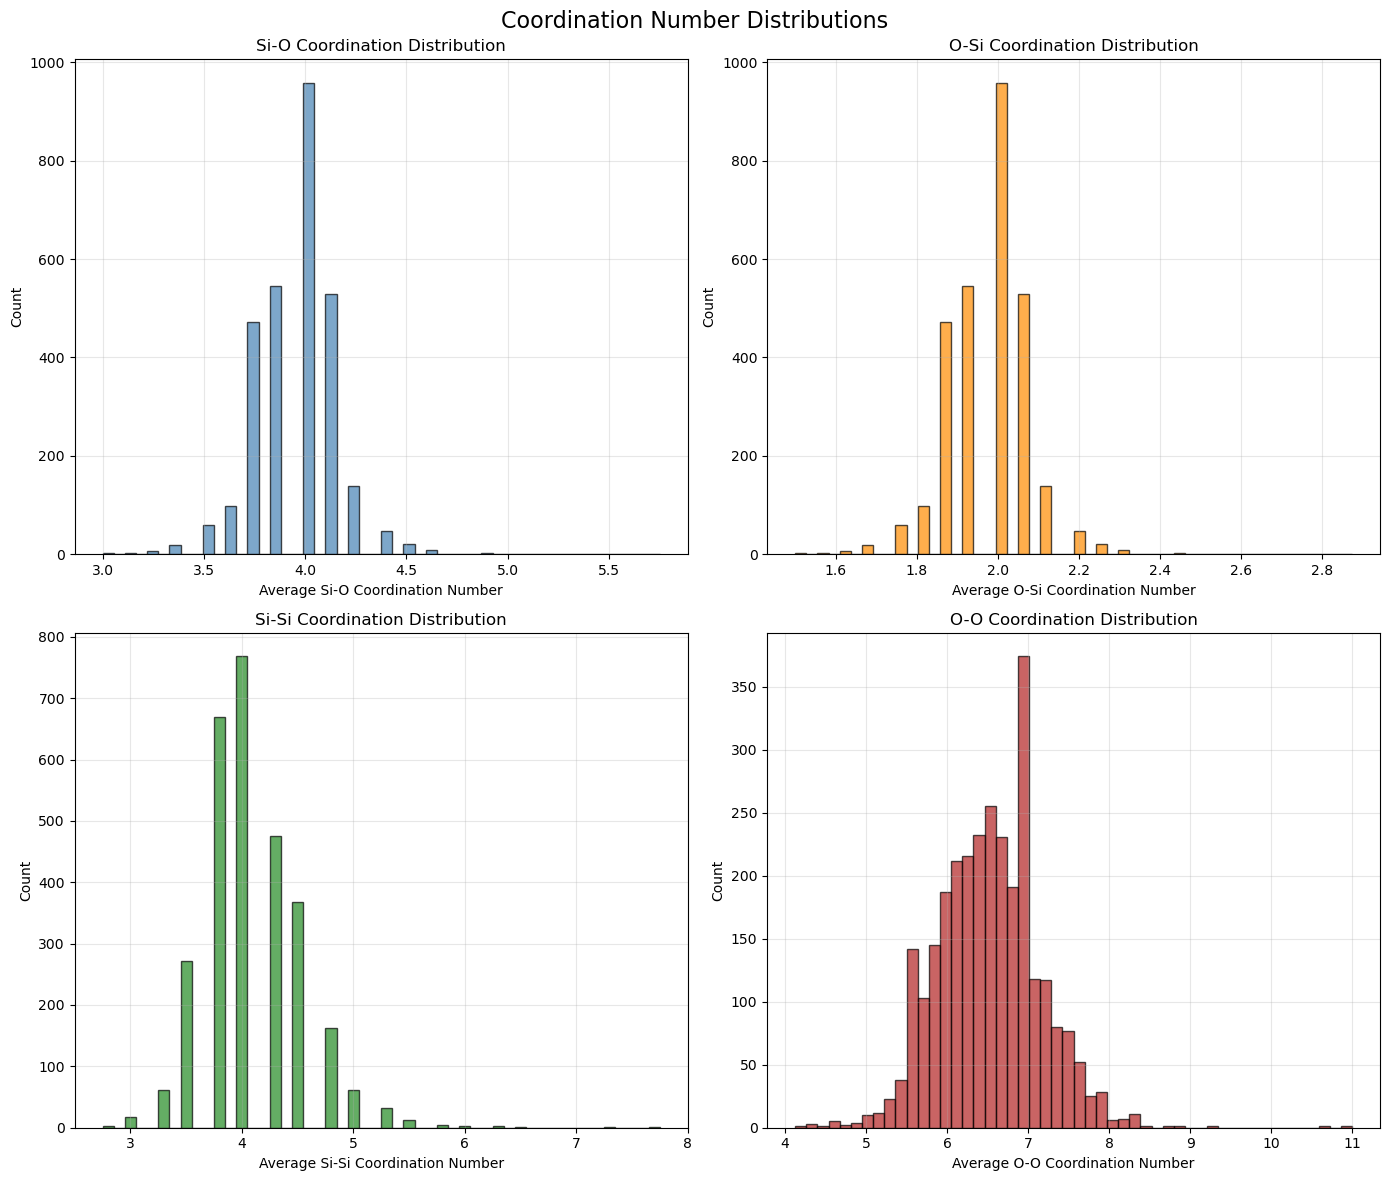

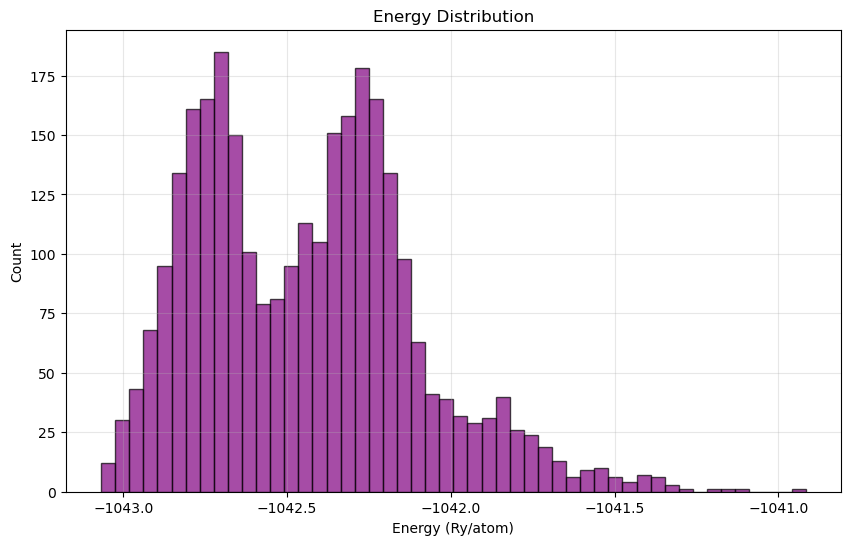


Statistics for 2914 structures:
Energy range: -1043.0680 - -1040.9165 Ry/atom
Energy mean: -1042.4400 ± 0.3343 Ry/atom
Si-O coordination: 3.96 ± 0.20
O-Si coordination: 1.98 ± 0.10
Si-Si coordination: 4.07 ± 0.44
O-O coordination: 6.52 ± 0.62


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf

def calculate_coordination_number(structure, element_pair=('Si', 'O'), r_cutoff=2.5):
    """
    Calculate average coordination number for a given element pair.
    
    Parameters:
    -----------
    structure : pymatgen Structure
        The structure to analyze
    element_pair : tuple
        (center_element, neighbor_element) 
    r_cutoff : float
        Cutoff radius for coordination shell
        
    Returns:
    --------
    float : Average coordination number
    """
    center_element, neighbor_element = element_pair
    
    # Get all sites of the center element
    center_sites = [site for site in structure.sites if site.specie.symbol == center_element]
    
    if len(center_sites) == 0:
        return 0.0
    
    total_coordination = 0
    
    for center_site in center_sites:
        # Get neighbors within cutoff radius
        neighbors = structure.get_neighbors(center_site, r_cutoff)
        
        # Count neighbors of the specified type
        coord_count = 0
        for neighbor_info in neighbors:
            neighbor_site = neighbor_info[0]
            distance = neighbor_info[1]
            
            if neighbor_site.specie.symbol == neighbor_element:
                # Skip self-interaction for same-element pairs
                if (center_element == neighbor_element and 
                    np.allclose(center_site.coords, neighbor_site.coords, atol=1e-3)):
                    continue
                coord_count += 1
        
        total_coordination += coord_count
    
    return total_coordination / len(center_sites)

# Load structures using your existing approach
folder_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/3k_poscar"
vasp_files = [f for f in os.listdir(folder_path) if f.endswith('.vasp')]
struct_ids = [int(f.replace('.vasp', '')) for f in vasp_files]
struct_ids.sort()

# Initialize structure manager
sm = StructureManager(struct_ids)

# Load data using existing methods
energies = sm.load_energies()
structures = sm.load_structures()

# Calculate coordination numbers
print(f"Calculating coordination numbers for {len(struct_ids)} structures...")

energies_list = []
coord_numbers_si_o = []
coord_numbers_o_si = []
coord_numbers_si_si = []
coord_numbers_o_o = []

for i, struct_id in enumerate(struct_ids):
    if i % 100 == 0:
        print(f"Processed {i}/{len(struct_ids)} structures")
    
    if struct_id in energies and struct_id in structures:
        try:
            structure = structures[struct_id]
            energy = energies[struct_id]
            
            # Calculate coordination numbers for different element pairs
            coord_si_o = calculate_coordination_number(structure, ('Si', 'O'), r_cutoff=2.5)
            coord_o_si = calculate_coordination_number(structure, ('O', 'Si'), r_cutoff=2.5)
            coord_si_si = calculate_coordination_number(structure, ('Si', 'Si'), r_cutoff=3.5)
            coord_o_o = calculate_coordination_number(structure, ('O', 'O'), r_cutoff=3.0)
            
            energies_list.append(energy)
            coord_numbers_si_o.append(coord_si_o)
            coord_numbers_o_si.append(coord_o_si)
            coord_numbers_si_si.append(coord_si_si)
            coord_numbers_o_o.append(coord_o_o)
            
        except Exception as e:
            print(f"Error processing structure {struct_id}: {e}")
            continue

# Convert to numpy arrays
energies_array = np.array(energies_list)
coord_numbers_si_o = np.array(coord_numbers_si_o)
coord_numbers_o_si = np.array(coord_numbers_o_si)
coord_numbers_si_si = np.array(coord_numbers_si_si)
coord_numbers_o_o = np.array(coord_numbers_o_o)

# Create hexbin plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Energy vs Average Coordination Number (Hexbin)', fontsize=16, y=0.98)

# Increase gridsize for higher fidelity
gridsize = 25

# Si-O coordination
hb1 = axes[0,0].hexbin(energies_array, coord_numbers_si_o, gridsize=gridsize, cmap='Blues', mincnt=1)
axes[0,0].set_xlabel('Energy (Ry/atom)')
axes[0,0].set_ylabel('Average Si-O Coordination Number')
axes[0,0].set_title('Si-O Coordination')
axes[0,0].grid(True, alpha=0.3)
cb1 = plt.colorbar(hb1, ax=axes[0,0])
cb1.set_label('Count')

# O-Si coordination
hb2 = axes[0,1].hexbin(energies_array, coord_numbers_o_si, gridsize=gridsize, cmap='Oranges', mincnt=1)
axes[0,1].set_xlabel('Energy (Ry/atom)')
axes[0,1].set_ylabel('Average O-Si Coordination Number')
axes[0,1].set_title('O-Si Coordination')
axes[0,1].grid(True, alpha=0.3)
cb2 = plt.colorbar(hb2, ax=axes[0,1])
cb2.set_label('Count')

# Si-Si coordination
hb3 = axes[1,0].hexbin(energies_array, coord_numbers_si_si, gridsize=gridsize, cmap='Greens', mincnt=1)
axes[1,0].set_xlabel('Energy (Ry/atom)')
axes[1,0].set_ylabel('Average Si-Si Coordination Number')
axes[1,0].set_title('Si-Si Coordination')
axes[1,0].grid(True, alpha=0.3)
cb3 = plt.colorbar(hb3, ax=axes[1,0])
cb3.set_label('Count')

# O-O coordination
hb4 = axes[1,1].hexbin(energies_array, coord_numbers_o_o, gridsize=gridsize, cmap='Reds', mincnt=1)
axes[1,1].set_xlabel('Energy (Ry/atom)')
axes[1,1].set_ylabel('Average O-O Coordination Number')
axes[1,1].set_title('O-O Coordination')
axes[1,1].grid(True, alpha=0.3)
cb4 = plt.colorbar(hb4, ax=axes[1,1])
cb4.set_label('Count')

plt.tight_layout()
plt.show()

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Coordination Number Distributions', fontsize=16, y=0.98)

# Increase bins for higher fidelity
bins = 50

# Si-O coordination distribution
axes[0,0].hist(coord_numbers_si_o, bins=bins, alpha=0.7, color='steelblue', edgecolor='black')
axes[0,0].set_xlabel('Average Si-O Coordination Number')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Si-O Coordination Distribution')
axes[0,0].grid(True, alpha=0.3)

# O-Si coordination distribution
axes[0,1].hist(coord_numbers_o_si, bins=bins, alpha=0.7, color='darkorange', edgecolor='black')
axes[0,1].set_xlabel('Average O-Si Coordination Number')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('O-Si Coordination Distribution')
axes[0,1].grid(True, alpha=0.3)

# Si-Si coordination distribution
axes[1,0].hist(coord_numbers_si_si, bins=bins, alpha=0.7, color='forestgreen', edgecolor='black')
axes[1,0].set_xlabel('Average Si-Si Coordination Number')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Si-Si Coordination Distribution')
axes[1,0].grid(True, alpha=0.3)

# O-O coordination distribution
axes[1,1].hist(coord_numbers_o_o, bins=bins, alpha=0.7, color='firebrick', edgecolor='black')
axes[1,1].set_xlabel('Average O-O Coordination Number')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('O-O Coordination Distribution')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Energy distribution
plt.figure(figsize=(10, 6))
plt.hist(energies_array, bins=bins, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Energy (Ry/atom)')
plt.ylabel('Count')
plt.title('Energy Distribution')
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f"\nStatistics for {len(energies_array)} structures:")
print(f"Energy range: {np.min(energies_array):.4f} - {np.max(energies_array):.4f} Ry/atom")
print(f"Energy mean: {np.mean(energies_array):.4f} ± {np.std(energies_array):.4f} Ry/atom")
print(f"Si-O coordination: {np.mean(coord_numbers_si_o):.2f} ± {np.std(coord_numbers_si_o):.2f}")
print(f"O-Si coordination: {np.mean(coord_numbers_o_si):.2f} ± {np.std(coord_numbers_o_si):.2f}")
print(f"Si-Si coordination: {np.mean(coord_numbers_si_si):.2f} ± {np.std(coord_numbers_si_si):.2f}")
print(f"O-O coordination: {np.mean(coord_numbers_o_o):.2f} ± {np.std(coord_numbers_o_o):.2f}")

NameError: name 'streak_results' is not defined